# Melting Uncertainties

This aims to estimate the uncertainty of the crystal melting rates,
combining the uncertainties of the dynamics and that of the rates calculation.

In [1]:
import pandas
import uncertainties
import altair as alt
import numpy as np
import scipy.optimize
import uncertainties

import sys
sys.path.append("../src")
import figures

figures.use_my_theme()

## Error in Melting Rates

The error of the melting rates will be calculated
by taking the standard deviation of all the measurements

In [2]:
with pandas.HDFStore('../data/analysis/melting_clean.h5') as store:
    rates_df = store.get("rates")

In [3]:
rates_df["error_min"] = rates_df["mean"] - rates_df["error"]
rates_df["error_max"] = rates_df["mean"] + rates_df["error"]

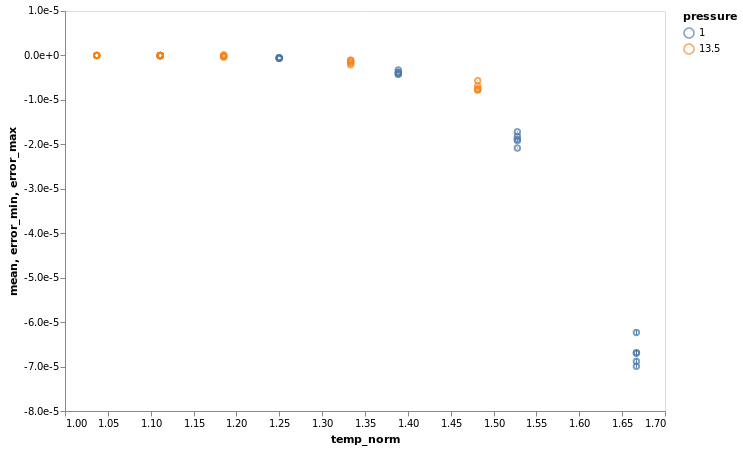

In [4]:
chart = alt.Chart(rates_df).encode(
    x=alt.X("temp_norm", scale=alt.Scale(zero=False)),
    y=alt.Y('mean', scale=alt.Scale(type='linear'), axis=alt.Axis(format='e')),
    color="pressure:N",
    
)

chart.mark_point() + chart.mark_rule().encode(y="error_min", y2="error_max")

In [5]:
melt_value = rates_df.groupby(["temperature","pressure", "temp_norm"])["mean"].mean()
melt_err = rates_df.groupby(["temperature", "pressure", "temp_norm"])["mean"].sem()
melt_frac_err = melt_err / melt_value
melt_df = pandas.DataFrame({
    "value": melt_value,
    "error": melt_err,
    "error_frac": melt_frac_err,
    "error_min": melt_value - 2 * melt_err,
    "error_max": melt_value + 2 * melt_err,
})

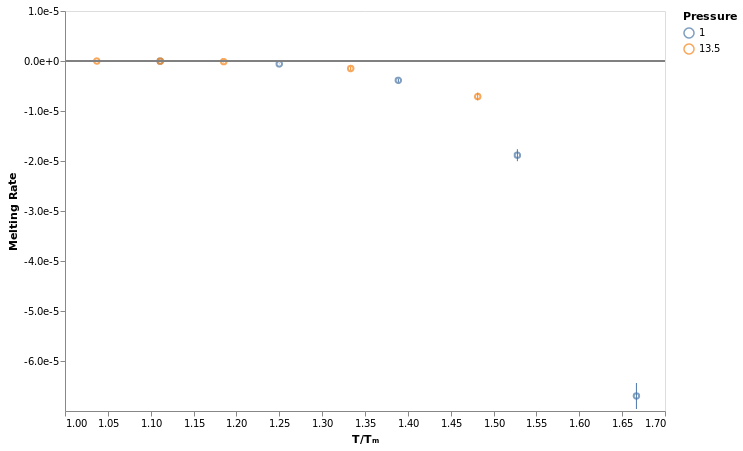

In [6]:
chart = alt.Chart(melt_df.reset_index()).encode(
    x=alt.X("temp_norm", title="T/Tₘ", scale=alt.Scale(zero=False)),
    color=alt.Color("pressure:N", title="Pressure"),
)

chart = (
    chart.mark_point().encode(
        y=alt.Y(
            "value", 
            title="Melting Rate", 
            axis=alt.Axis(format='e'),
        )
    ) +
    chart.mark_rule().encode(
        y="error_min", 
        y2="error_max"
    )
)

chart = figures.hline(chart, 0)
chart

In [7]:
chart.save("../figures/growth_rates_err.svg", webdriver="firefox")

In [8]:
mean = rates_df.groupby(["temperature","pressure", "temp_norm"])["mean"].mean()
err = rates_df.groupby(["temperature", "pressure", "temp_norm"])["mean"].std()

## Error in Rotational Relaxation

In [9]:
with pandas.HDFStore('../data/analysis/dynamics_clean_agg.h5') as store:
    relax_df = store.get("relaxations")

In [10]:
rot_value = relax_df.groupby(["temperature", "pressure"])["rot2_value"].mean()
rot_err = np.maximum((relax_df["rot2_value"] - relax_df["rot2_lower"]).values, (relax_df["rot2_upper"] - relax_df["rot2_value"]).values)
rot_frac_err = rot_err / rot_value

rot_df = pandas.DataFrame({
    "value": rot_value,
    "error": rot_err,
    "error_frac": rot_frac_err,
})

In [11]:
all_df = melt_df.reset_index("temp_norm").join(rot_df, lsuffix="_melt", rsuffix="_rot").set_index('temp_norm', append=True)
all_df.head()

,,,value_melt,error_melt,error_frac_melt,error_min,error_max,value_rot,error_rot,error_frac_rot
temperature,pressure,temp_norm,,,,,,,,
0.40,1.0,1.111111,-2.223193e-08,1.387009e-09,-0.062388,-2.500594e-08,-1.945791e-08,655540.0,8885.0,0.013554
0.45,1.0,1.250000,-5.825945e-07,2.861396e-08,-0.049115,-6.398224e-07,-5.253666e-07,NaN,NaN,NaN
0.50,1.0,1.388889,-3.868981e-06,1.699150e-07,-0.043917,-4.208811e-06,-3.529151e-06,58404.0,494.4,0.008465
0.55,1.0,1.527778,-1.883740e-05,6.009483e-07,-0.031902,-2.003930e-05,-1.763550e-05,35660.0,360.0,0.010095
0.60,1.0,1.666667,-6.700331e-05,1.299322e-06,-0.019392,-6.960196e-05,-6.440467e-05,22080.0,300.0,0.013587


In [12]:
value = all_df["value_melt"] * all_df["value_rot"]
err_frac = all_df["error_frac_melt"].abs() + all_df["error_frac_rot"].abs()
error = value * err_frac

melt_values = pandas.DataFrame({
    "value": value,
    "error": error,
    "error_min": value - 2 * error,
    "error_max": value + 2 * error,
}).reset_index().dropna()

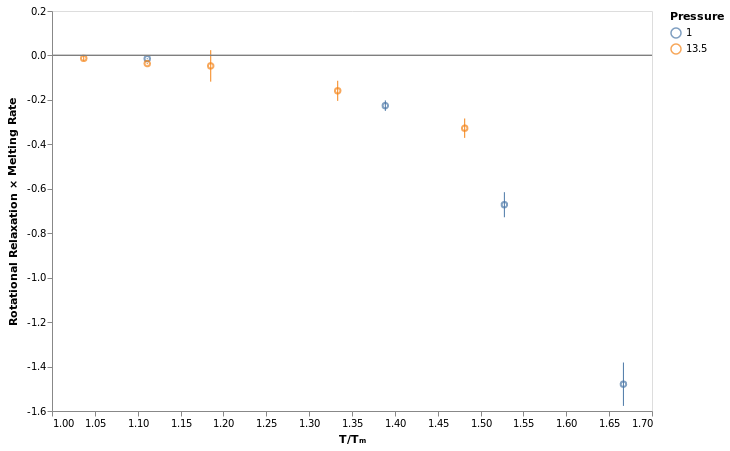

In [13]:
chart = alt.Chart(melt_values).encode(
    x=alt.X("temp_norm", title="T/Tₘ", scale=alt.Scale(zero=False)),
    color=alt.Color("pressure:N", title="Pressure"),
)

c = (
    chart.mark_point().encode(y=alt.Y("value", title="Rotational Relaxation × Melting Rate")) +
    chart.mark_rule().encode(y="error_min", y2="error_max")
)

c = figures.hline(c, 0)
c

## Fitting to Theory

When fitting a curve to the data
it is required to take into account
the errors in the data.

In [14]:
def fit_curve(x_vals, y_vals, errors=None, delta_E=None):
    if delta_E is None:
        def theory(x, c, d):
            result = 1 - np.exp((1-x) * d / x)
            return c * result
    else:
        def theory(x, c):
            result = 1 - np.exp((1-x) * delta_E / x)
            return c * result
    
    opt, err = scipy.optimize.curve_fit(
        theory, 
        x_vals, 
        y_vals,
        sigma=errors,
        maxfev=2000,
    )
    
    return theory, opt, err

In [15]:
import matplotlib.pyplot as plt

x = np.arange(0.95, 2.0, 0.05)

p1_values = melt_values.query("pressure == 1.00")
p13_values = melt_values.query("pressure == 13.50")

theory1, opt1, err1 = fit_curve(p1_values["temp_norm"], p1_values["value"], p1_values["error"], -0.18034612159032992)
theory13, opt13, err13 = fit_curve(p13_values["temp_norm"], p13_values["value"], p13_values["error"], -0.06561802006526474)

In [16]:
y1 = theory1(x, *opt1)
y13 = theory13(x, *opt13)

In [17]:
theory_df = melt_values
theory_df["theory"] = 0.
mask = theory_df["pressure"] == 1.00
theory_df.loc[mask, "theory"] = theory1(theory_df["temp_norm"], *opt1)
theory_df.loc[~mask, "theory"] = theory13(theory_df["temp_norm"], *opt13)

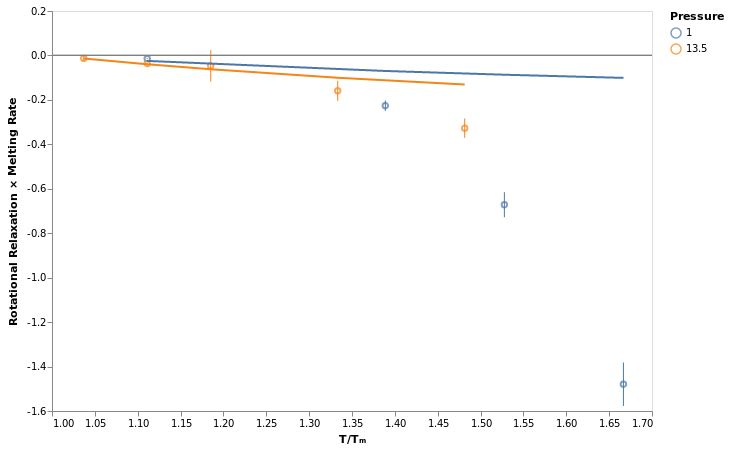

In [18]:
chart = alt.Chart(theory_df).encode(
    x=alt.X("temp_norm", title="T/Tₘ", scale=alt.Scale(zero=False)),
    color=alt.Color("pressure:N", title="Pressure"),
)

chart = (
    chart.mark_point().encode(y=alt.Y("value", title="Rotational Relaxation × Melting Rate")) +
    chart.mark_rule().encode(y="error_min", y2="error_max") +
    chart.mark_line().encode(y="theory")
)

chart = figures.hline(chart, 0.)
chart

In [19]:
chart.save("../figures/normalised_melting_err.svg", webdriver="firefox")

In [20]:
p1_values_2 = melt_values.query("pressure == 1.00")
p13_values_2 = melt_values.query("pressure == 13.50")

theory1_2, opt1_2, err1_2 = fit_curve(
    p1_values_2["temp_norm"], 
    p1_values_2["value"], 
    p1_values_2["error"],
)
theory13_2, opt13_2, err13_2 = fit_curve(
    p13_values_2["temp_norm"], 
    p13_values_2["value"], 
    p13_values_2["error"],
)

In [21]:
theory_df_2 = melt_values
theory_df_2["theory"] = 0.
mask = theory_df["pressure"] == 1.00
theory_df_2.loc[mask, "theory"] = theory1_2(theory_df_2["temp_norm"], *opt1_2)
theory_df_2.loc[~mask, "theory"] = theory13_2(theory_df_2["temp_norm"], *opt13_2)

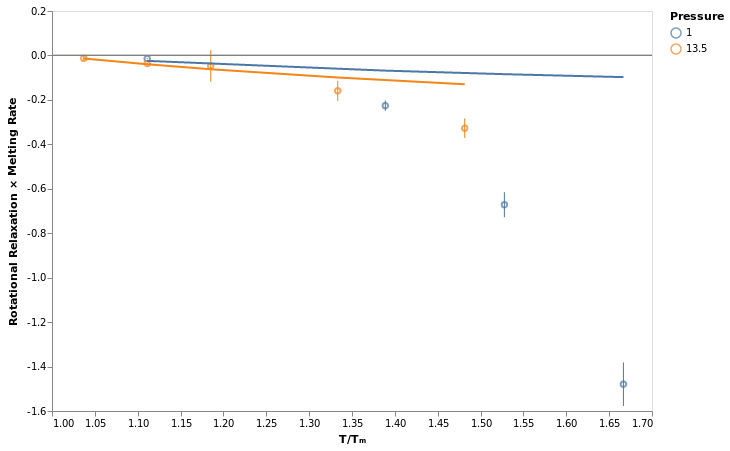

In [22]:
chart = alt.Chart(theory_df_2).encode(
    x=alt.X("temp_norm", title="T/Tₘ", scale=alt.Scale(zero=False)),
    color=alt.Color("pressure:N", title="Pressure"),
)

chart = (
    chart.mark_point().encode(y=alt.Y("value", title="Rotational Relaxation × Melting Rate")) +
    chart.mark_rule().encode(y="error_min", y2="error_max") +
    chart.mark_line().encode(y="theory")
)

chart = figures.hline(chart, 0.)
chart

In [23]:
opt13_2

array([-6.76055980e+02,  5.90013197e-04])